In [1]:
import glob
import librosa
import librosa.display
from matplotlib import pyplot as plt
import numpy as np
import os
import tqdm
import scipy
import soundfile as sf


subfolder_str = "BirdVox-pcen"
data_dir = '/beegfs/vl1019/spl2018_datasets'

%matplotlib inline

indoor_settings = {
    "fmin": 2000,
    "fmax": 11025,
    "hop_length": 32,
    "n_fft": 1024,
    "n_mels": 128,
    "sr": 22050,
    "win_length": 256,
    "window": "hann",
    "T": 0.4,
    "alpha": 0.98,
    "delta": 2.0,
    "r": 0.5,
    "eps": 1e-6}


outdoor_settings = {
    "fmin": 2000,
    "fmax": 11025,
    "hop_length": 32,
    "n_fft": 1024,
    "n_mels": 128,
    "sr": 22050,
    "win_length": 256,
    "window": "flattop",
    "T": 0.06,
    "alpha": 0.8,
    "delta": 10.0,
    "r": 0.25,
    "eps": 1e-6}




subfolder_dir = os.path.join(data_dir, subfolder_str)
wav_names = list(glob.glob(os.path.join(subfolder_dir, "*.wav")))
wav_paths = sorted([os.path.join(subfolder_dir, x) for x in wav_names])
n_files = len(wav_paths)

log_list, indoor_list, outdoor_list = [], [], []

for file_id in tqdm.tqdm(range(n_files)):
    wav_path = wav_paths[file_id]
    
    waveform_file = sf.SoundFile(wav_path)
    waveform_length = len(waveform_file)
    sample_rate = waveform_file.samplerate
    waveform_file.seek(0)
    waveform = waveform_file.read(waveform_length)
    waveform = librosa.resample(
        waveform, sample_rate, outdoor_settings["sr"])
    waveform = waveform * (2**31)
    
    
    ## "INDOOR" MODE.
    # The settings are the same for indoor and outdoor here.
    indoor_stft = librosa.stft(
        waveform,
        n_fft=indoor_settings["n_fft"],
        win_length=indoor_settings["win_length"],
        hop_length=indoor_settings["hop_length"],
        window=indoor_settings["window"])

    indoor_abs2_stft = (indoor_stft.real*indoor_stft.real) + (indoor_stft.imag*indoor_stft.imag)
    
    indoor_E = librosa.feature.melspectrogram(
        y=None,
        S=indoor_abs2_stft,
        sr=indoor_settings["sr"],
        n_fft=indoor_settings["n_fft"],
        n_mels=indoor_settings["n_mels"],
        htk=True,
        fmin=indoor_settings["fmin"],
        fmax=indoor_settings["fmax"])

    indoor_PCEN = librosa.pcen(
        S=indoor_E,
        time_constant=indoor_settings["T"],
        sr=indoor_settings["sr"],
        hop_length=indoor_settings["hop_length"],
        gain=indoor_settings["alpha"],
        power=indoor_settings["r"],
        bias=indoor_settings["delta"],
        eps=indoor_settings["eps"])
    
    
    ## "OUTDOOR" MODE.
    outdoor_stft = librosa.stft(
        waveform,
        n_fft=outdoor_settings["n_fft"],
        win_length=outdoor_settings["win_length"],
        hop_length=outdoor_settings["hop_length"],
        window=outdoor_settings["window"])

    outdoor_abs2_stft = (outdoor_stft.real*outdoor_stft.real) + (outdoor_stft.imag*outdoor_stft.imag)
    
    outdoor_E = librosa.feature.melspectrogram(
        y=None,
        S=outdoor_abs2_stft,
        sr=outdoor_settings["sr"],
        n_fft=outdoor_settings["n_fft"],
        n_mels=outdoor_settings["n_mels"],
        htk=True,
        fmin=outdoor_settings["fmin"],
        fmax=outdoor_settings["fmax"])
        
    outdoor_PCEN = librosa.pcen(
        S=outdoor_E,
        time_constant=outdoor_settings["T"],
        sr=outdoor_settings["sr"],
        hop_length=outdoor_settings["hop_length"],
        gain=outdoor_settings["alpha"],
        power=outdoor_settings["r"],
        bias=outdoor_settings["delta"],
        eps=outdoor_settings["eps"])


    indoor_E_ravel = indoor_E.ravel()
    log_E_ravel = np.log(1e-6+indoor_E_ravel)
    indoor_PCEN_ravel = indoor_PCEN.ravel()
    outdoor_PCEN_ravel = outdoor_PCEN.ravel()
    
    log_list.append(log_E_ravel)
    indoor_list.append(indoor_PCEN_ravel)
    outdoor_list.append(outdoor_PCEN_ravel)

100%|██████████| 15/15 [00:59<00:00,  3.91s/it]


/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


-1.8362394950874703
7.14931805137747


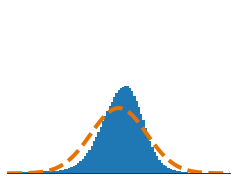

5.763896002252635
156.88543353640267


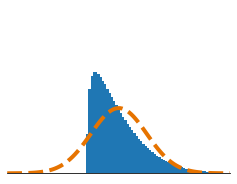

0.17359274203689856
-0.3374535200140487


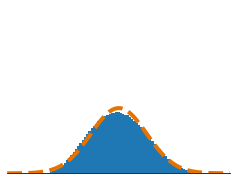

-2.017297883602169
7.960028800542638


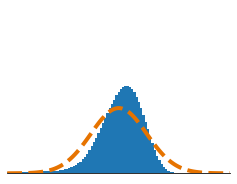

6.69494479562971
150.96853938249342


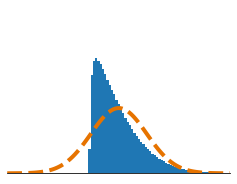

0.31846181548370567
0.4531015909349936


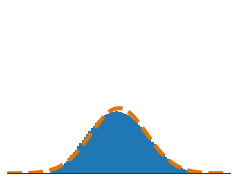

-1.966339471100066
7.634559658742443


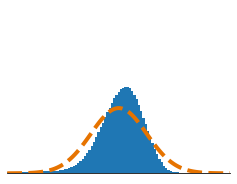

5.591776987438916
135.24681597691648


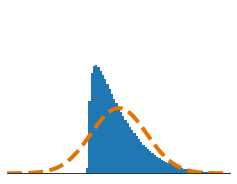

0.21330394774324407
-0.20680645335296344


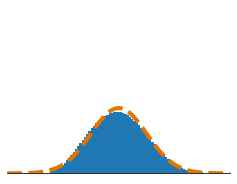

-0.36259664225681193
0.9481640651217118


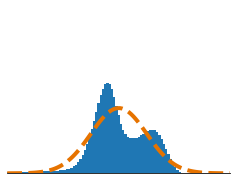

5.425823842670182
114.44416911937086


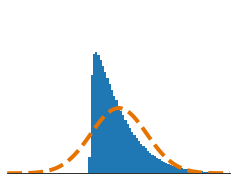

0.5367284082457952
0.14448723435131416


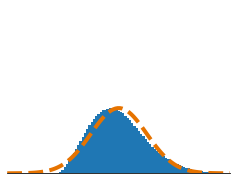

0.2541698470057744
-0.5308604037565936


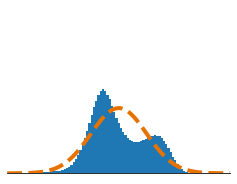

5.587897923440139
137.63874360721658


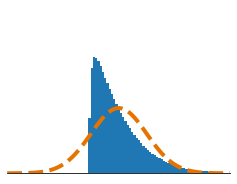

0.5139407927632695
0.09305749026520083


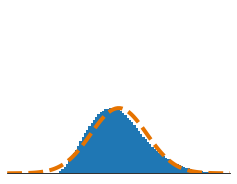

-0.18556405180232327
2.984199558292527


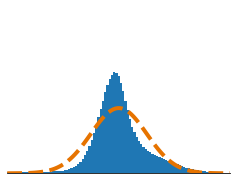

6.290004736310774
116.21206975572204


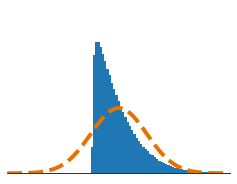

0.5838509419049178
0.7141272603773356


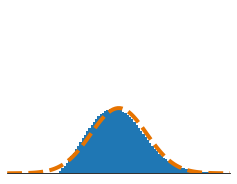

-0.18556405180232327
2.984199558292527


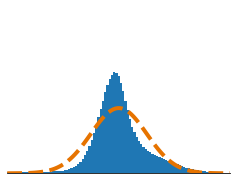

6.290004736310774
116.21206975572204


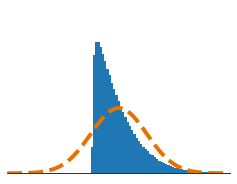

0.5838509419049178
0.7141272603773356


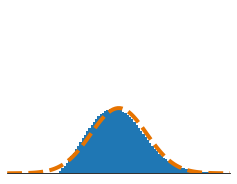

0.11278803857871819
1.1126150454929569


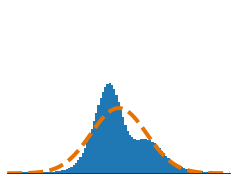

5.377102885799189
122.40502491440446


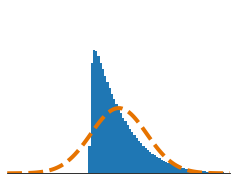

0.5113028569917035
0.2647579532785489


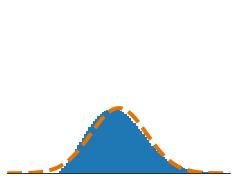

-0.8453825058480843
3.9950594493076688


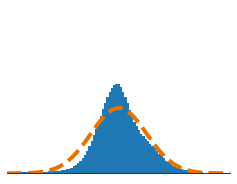

6.4543550358207185
151.11800292148888


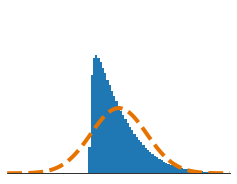

0.44777779049531874
0.24632685834061308


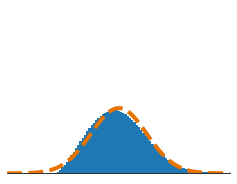

-0.21156662363751894
1.3766293916940215


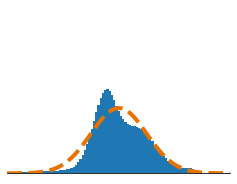

5.01258969508342
116.28955098252848


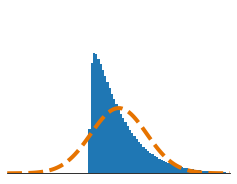

0.7650882926718822
0.8682907645695268


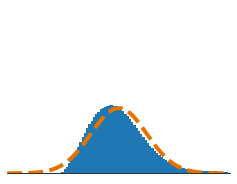

-0.26510604824131495
1.2592724540285518


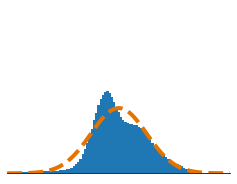

5.667692140521957
141.70176117253288


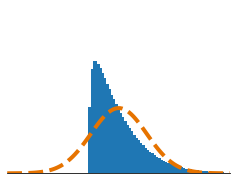

0.5954749756930838
0.3413977724551822


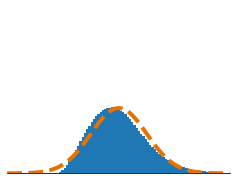

0.006174442015400149
0.38172531415075506


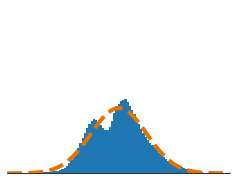

6.948667347894971
86.89457644719808


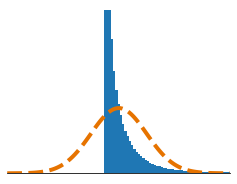

1.0666975527272993
2.105495874665986


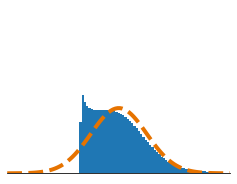

-1.518718724389572
6.608369636979511


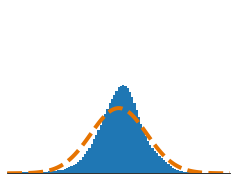

5.805223799061039
136.88448947373396


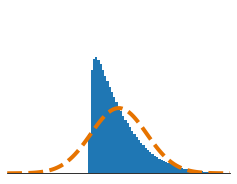

0.2976061053670548
-0.10494296655543023


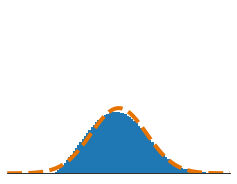

-1.3454487571982152
5.0404620922802295


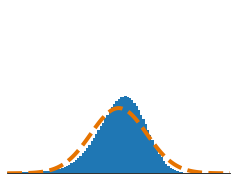

5.720648858375491
129.4539599748809


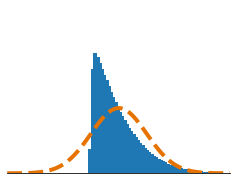

0.23812546949038194
-0.16335881224174775


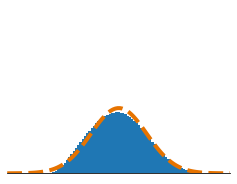

0.28946204709067125
1.8695054472878594


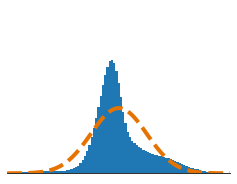

6.411884999382553
106.19004083566422


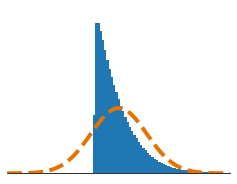

0.7425660135528992
1.0060628040865058


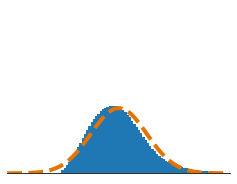

In [3]:
for file_id in range(n_files):
    file_ids = [file_id]
    log_E_ravel = np.concatenate([log_list[i] for i in file_ids])
    indoor_PCEN_ravel = np.concatenate([indoor_list[i] for i in file_ids])
    outdoor_PCEN_ravel = np.concatenate([outdoor_list[i] for i in file_ids])
    
    wav_path = wav_paths[file_id]
    wav_name = os.path.split(wav_path)[1][:-4]

    figsize = (4, 3)
    fig = plt.figure(figsize=figsize)
    xgauss = np.linspace(-4, 4, 100)
    hist_x = plt.hist(
        (log_E_ravel - np.mean(log_E_ravel)) / np.std(log_E_ravel),
        bins=xgauss);
    hist_step = np.diff(hist_x[1])[0]
    gaussmax = len(log_E_ravel)/np.sqrt(2*np.pi) * hist_step
    ygauss = gaussmax * np.exp(-(xgauss*xgauss)/2)
    plt.plot(xgauss, ygauss, '--', color="#E67300", linewidth=4.0)
    plt.xlim([-4,4])
    plt.ylim([0, 2.5*gaussmax])
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tick_params(labelleft="off", left="off")
    print(scipy.stats.skew(log_E_ravel))
    print(scipy.stats.kurtosis(log_E_ravel))
    plt.gca().axes.get_xaxis().set_visible(False)
    #fig.savefig(subfolder_str + "_" + wav_name + '_logE_histogram.eps',
    #    transparent=True, bbox_inches="tight")
    plt.show()


    fig = plt.figure(figsize=figsize, frameon=False)
    plt.hist((indoor_PCEN_ravel - np.mean(indoor_PCEN_ravel)) / np.std(indoor_PCEN_ravel), bins=xgauss);
    plt.plot(xgauss, ygauss, '--', color="#E67300", linewidth=4.0)
    plt.xlim([-4,4])
    plt.ylim([0, 2.5*gaussmax])
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tick_params(labelleft="off", left="off")
    print(scipy.stats.skew(indoor_PCEN_ravel))
    print(scipy.stats.kurtosis(indoor_PCEN_ravel))
    plt.gca().axes.get_xaxis().set_visible(False)
    #fig.savefig(subfolder_str + "_" + wav_name + '_indoor-PCEN_histogram.eps',
    #    transparent=True, bbox_inches="tight")
    plt.show()


    fig = plt.figure(figsize=figsize, frameon=False)
    plt.hist((outdoor_PCEN_ravel - np.mean(outdoor_PCEN_ravel)) / np.std(outdoor_PCEN_ravel), bins=xgauss);
    plt.plot(xgauss, ygauss, '--', color="#E67300", linewidth=4.0)
    plt.xlim([-4,4])
    plt.ylim([0, 2.5*gaussmax])
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tick_params(labelleft="off", left="off")
    print(scipy.stats.skew(outdoor_PCEN_ravel))
    print(scipy.stats.kurtosis(outdoor_PCEN_ravel))
    plt.gca().axes.get_xaxis().set_visible(False)
    #fig.savefig(subfolder_str + "_" + wav_name + '_outdoor-PCEN_histogram.eps',
    #    transparent=True, bbox_inches="tight")
    plt.show()

In [8]:
log_hists = []
indoor_hists = []
outdoor_hists = []

all_log_E_ravel = np.concatenate(log_list)
all_indoor_ravel = np.concatenate(indoor_list)
all_outdoor_ravel = np.concatenate(outdoor_list)

for file_id in tqdm.tqdm(range(n_files)):
    file_ids = [file_id]
    log_E_ravel = np.concatenate([log_list[i] for i in file_ids])
    indoor_PCEN_ravel = np.concatenate([indoor_list[i] for i in file_ids])
    outdoor_PCEN_ravel = np.concatenate([outdoor_list[i] for i in file_ids])
    
    wav_path = wav_paths[file_id]
    wav_name = os.path.split(wav_path)[1][:-4]
    
    if wav_name == "unit10_00-00-50": # this is a mic check, not an outdoor recording
        continue

    xgauss = np.linspace(-4, 4, 100)
    hist_x = np.histogram(
        (log_E_ravel - np.mean(all_log_E_ravel)) / np.std(all_log_E_ravel),
        bins=xgauss)[0];
    log_hists.append(hist_x)

    hist_x = np.histogram(
        (indoor_PCEN_ravel - np.mean(all_indoor_ravel)) / np.std(all_indoor_ravel),
        bins=xgauss)[0];
    indoor_hists.append(hist_x)
    
    hist_x = np.histogram(
    (outdoor_PCEN_ravel - np.mean(all_outdoor_ravel)) / np.std(all_outdoor_ravel),
    bins=xgauss)[0];
    outdoor_hists.append(hist_x)

100%|██████████| 15/15 [00:36<00:00,  2.44s/it]


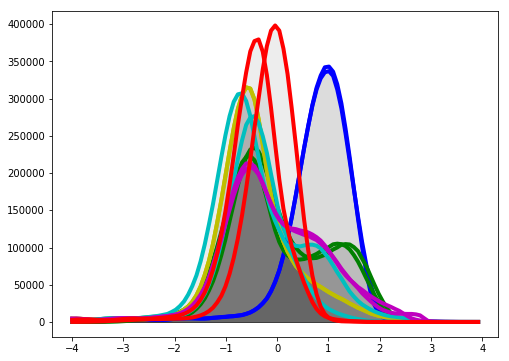

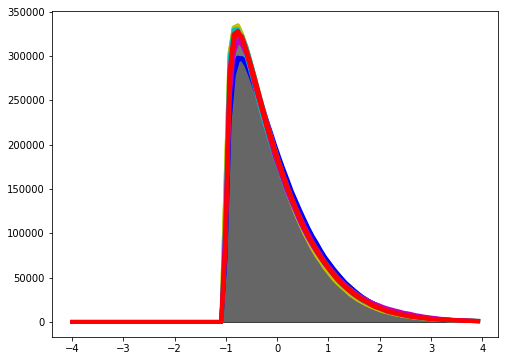

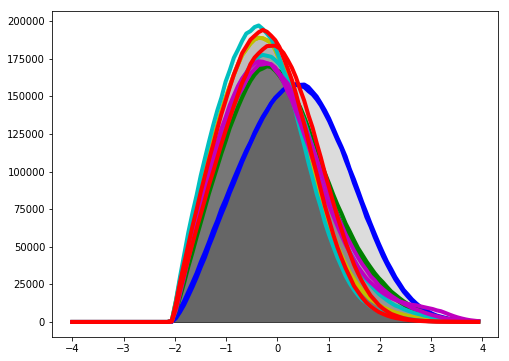

In [10]:
figsize = (8, 6)

color_scheme = {
    "unit01": "b",
    "unit02": "g",
    "unit03": "y",
    "unit05": "c",
    "unit07": "m",
    "unit10": "r"
}
colors = [color_scheme[os.path.split(x)[1][:6]] for x in wav_paths
         if not os.path.split(x)[1][:-4] == "unit10_00-00-50"]


# We restrict to exactly 2 recordings per unit.
for tfr_hist in [log_hists, indoor_hists, outdoor_hists]:
    plt.figure(figsize=figsize)
    for tfr_hist_recording, color in zip(tfr_hist[1:-1], colors[1:-1]):
        plt.plot(xgauss[:-1], tfr_hist_recording, '-', color=color, linewidth=4.0);
        alpha=1/14
        plt.fill_between(xgauss[:-1], tfr_hist_recording, color='k', alpha=alpha)

In [155]:
colors[1:-1]

['b', 'b', 'g', 'g', 'y', 'y', 'c', 'c', 'm', 'm', 'r', 'r']

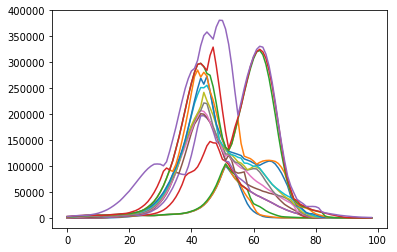

In [55]:
plt.plot(np.percentile(np.stack(log_hists).T, q=np.linspace(0, 100, 15), axis=1).T);

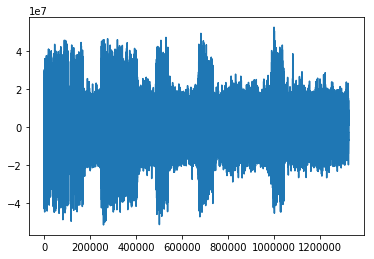

In [74]:
wav_path = wav_paths[7]
waveform_file = sf.SoundFile(wav_path)
waveform_length = len(waveform_file)
sample_rate = waveform_file.samplerate
waveform_file.seek(0)
waveform = waveform_file.read(waveform_length)
waveform = librosa.resample(
    waveform, sample_rate, outdoor_settings["sr"])
waveform = waveform * (2**31)
plt.plot(waveform)

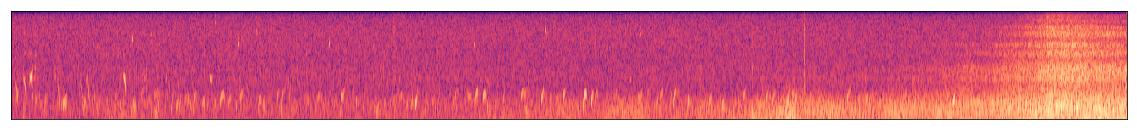

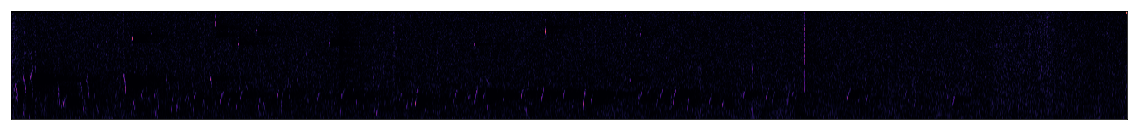

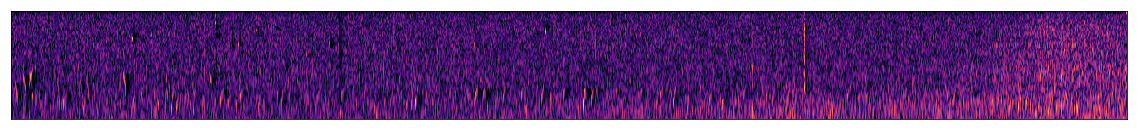

In [5]:
from librosa.display import specshow

plt.figure(figsize=(20,2))
specshow(np.log(outdoor_E))
plt.show()

plt.figure(figsize=(20,2))
specshow(np.clip(indoor_PCEN, 0, np.inf))
plt.show()

plt.figure(figsize=(20,2))
specshow(outdoor_PCEN)
plt.show()

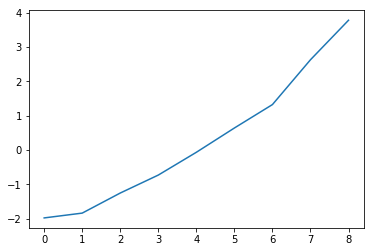

In [13]:
plt.plot(np.percentile((outdoor_PCEN_ravel - np.mean(outdoor_PCEN_ravel)) / np.std(outdoor_PCEN_ravel), [0.1, 1, 10, 25, 50, 75, 90, 99, 99.9]))

In [20]:

wav_name

'unit10_07-54-24'